# Finra gets data from various exchanges and posts it on a daily basis. The idea of a project is that when during 3 days in a row short volume for a specific stock moves in the same direction it is an indicator to daytrade the stock for the following day.
## We got 105 such stocks for the period from Feb 16 till Feb 18. And in order to reduce that list(that we actually reduced down to just 3) we use FinViz scanner.

In [ ]:
author = 'Nikolai Melnikov'
author_url = 'https://www.linkedin.com/in/nikolaimelnikov/'

Installing packages in Colab

In [ ]:
!pip install yfinance
!pip install -U git+https://github.com/mariostoev/finviz

Importing packages for the project

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from urllib.request import Request, urlopen  

import datetime
from datetime import date, timedelta, datetime
from pytz import timezone

import yfinance as yf
from pandas_datareader import data as pdr
from finviz.screener import Screener

import nest_asyncio
nest_asyncio.apply()

# MAKE FOLLOWING CODE AS FUNCTION FOR SPECIFIC DAY, REMEMBER ABOUT WEEKENDS

In [ ]:
#Creating the URL request
def url(req):
  req.add_header('User-Agent', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0')
  content = urlopen(req)
  return content  

#Creating a DF for an exchange
def mini_db(content):
  db = pd.read_csv(content, sep='|')
  db.drop(db.tail(1).index,inplace=True)
  db['Date'] =  pd.to_datetime(db['Date'], format='%Y%m%d')
  db = db[['Symbol','ShortVolume', 'Date']]
  return db 

#Combining data from exchanges for a specific date
def db(df_finra, df_nasdaq_trf, df_nyse):
  db = df_nyse.merge(df_nasdaq_trf, how='inner', on='Symbol')
  db = db.merge(df_finra, how='inner', on='Symbol')
  db.set_index('Symbol', inplace=True)
  db['Date'] = db['Date_x']
  db.set_index('Date', append=True, inplace=True)
  db.index = db.index.reorder_levels(['Date', 'Symbol'])
  db.drop(['Date_x','Date_y'], axis=1, inplace=True)
  return db

#Main function to get data
def req(date):
  req = Request(f'http://regsho.finra.org/CNMSshvol{date}.txt')
  content = url(req)
  df_finra = mini_db(content)

  req = Request(f'http://regsho.finra.org/FNSQshvol{date}.txt')
  content = url(req)
  df_nasdaq_trf = mini_db(content)

  req = Request(f'http://regsho.finra.org/FNYXshvol{date}.txt')
  content = url(req)
  df_nyse = mini_db(content)

  return db(df_finra, df_nasdaq_trf, df_nyse)
  
#Checking a weekday
def check_weekend(day):
  if (day.weekday() == 6):
    day = day - timedelta(days=2)
  elif (day.weekday() == 5):
    day = day - timedelta(days=1)
  else:
    pass
  return day

#transform date for Finra's format
def date_trans(day):
  return day.strftime("%Y")+day.strftime("%m")+day.strftime("%d")

#Getting dates for performing analysis
def get_day(day):
  day = check_weekend(day)
  day_before = check_weekend(day - timedelta(days=1))
  day_before_before = check_weekend(day_before - timedelta(days=1))
  return date_trans(day), date_trans(day_before), date_trans(day_before_before)

In [ ]:
tz = timezone('EST')
today = datetime.now(tz) 

result = get_day(today)
date_start = result[0]
date_before = result[1]
date_before_before = result[2]

analysis = req(date_start)
analysis_1 = req(date_before)
analysis_2 = req(date_before_before)

In [ ]:
#Combine data from 3 days in a single DF
df = pd.concat([analysis_2,analysis_1])
df = pd.concat([df, analysis])

In [ ]:
df

ShortVolume_x  ShortVolume_y  ShortVolume
Date       Symbol                                           
2021-02-16 A             19825.0       160072.0     180074.0
           AA            95606.0       383580.0     481705.0
           AAAU           5488.0        40264.0      45752.0
           AAC/U           155.0        75555.0      75710.0
           AACG          63409.0       249707.0     335763.0
...                          ...            ...          ...
2021-02-18 ZVO           15323.0        25170.0      40768.0
           ZWRKU          4678.0        11205.0      16083.0
           ZYME           7359.0        36507.0      44380.0
           ZYNE         556884.0      1621489.0    2204717.0
           ZYXI           8126.0        47741.0      55867.0

[25419 rows x 3 columns]

Check what stocks had a short volume increase 3 days in a row.

In [ ]:
df['VolumeDivDay'] = df['ShortVolume_x'] - df.groupby(level=1)['ShortVolume_x'].shift()
df['VolumeDivDayBefore'] = df['ShortVolume_y'] - df.groupby(level=1)['ShortVolume_y'].shift()
df['VolumeDivDayBeforeBefore'] = df['ShortVolume'] - df.groupby(level=1)['ShortVolume'].shift()

df['DipDay'] = df['VolumeDivDay'] - df.groupby(level=1)['VolumeDivDay'].shift()
df['DipDayBefore'] = df['VolumeDivDayBefore'] - df.groupby(level=1)['VolumeDivDayBefore'].shift()
df['DipDayBeforeBefore'] = df['VolumeDivDayBeforeBefore'] - df.groupby(level=1)['VolumeDivDayBeforeBefore'].shift()

df['DifDay'] = np.where((df['VolumeDivDay'] >= df['DipDay']), df['VolumeDivDay'], np.nan)
df['DifDayBefore'] = np.where((df['VolumeDivDayBefore'] >= df['DipDayBefore']), df['VolumeDivDayBefore'], np.nan)
df['DifDayBeforeBefore'] = np.where((df['VolumeDivDayBeforeBefore'] >= df['DipDayBeforeBefore']), df['VolumeDivDayBeforeBefore'], np.nan)
 
df.dropna(inplace=True)

analyze = df[(df['DipDay'] > 0 )&(df['DipDayBefore'] > 0) & (df['DipDayBeforeBefore'] > 0) & (df['VolumeDivDay'] > 0 )&(df['VolumeDivDayBefore'] > 0) & (df['VolumeDivDayBeforeBefore'] > 0)]
analyze = analyze.droplevel(level=0)

In [ ]:
analyze

,ShortVolume_x,ShortVolume_y,ShortVolume,VolumeDivDay,VolumeDivDayBefore,VolumeDivDayBeforeBefore,DipDay,DipDayBefore,DipDayBeforeBefore,DifDay,DifDayBefore,DifDayBeforeBefore
Symbol,,,,,,,,,,,,
AAWW,9644.0,109944.0,119688.0,2903.0,61010.0,63350.0,910.0,39825.0,39719.0,2903.0,61010.0,63350.0
ABMD,6790.0,40703.0,47594.0,4392.0,11185.0,15662.0,3618.0,7932.0,11681.0,4392.0,11185.0,15662.0
ADAP,96215.0,424489.0,520804.0,25725.0,140751.0,164476.0,18659.0,81712.0,96631.0,25725.0,140751.0,164476.0
ANET,14508.0,102897.0,117542.0,7798.0,22111.0,30010.0,6863.0,7004.0,13982.0,7798.0,22111.0,30010.0
ARR,81803.0,360288.0,442091.0,42047.0,231101.0,265346.0,21336.0,173190.0,179422.0,42047.0,231101.0,265346.0
...,...,...,...,...,...,...,...,...,...,...,...,...
VNQI,24299.0,106249.0,130552.0,7453.0,35352.0,42759.0,3726.0,10584.0,14221.0,7453.0,35352.0,42759.0
WGO,14999.0,145783.0,160782.0,11715.0,98954.0,110569.0,11643.0,92233.0,103677.0,11715.0,98954.0,110569.0
WIX,96451.0,1048429.0,1144987.0,68979.0,669545.0,737178.0,49885.0,450983.0,498657.0,68979.0,669545.0,737178.0


In [ ]:
results = pd.DataFrame(columns=['Price','Diff','Diff1'])

ticker_list = analyze.index.tolist()

for ticker in ticker_list:
    try:
      data = pdr.get_data_yahoo(ticker, start=datetime.strptime(date_before_before, '%Y%m%d').date(), end=datetime.strptime(date_start, '%Y%m%d').date())
      temp = pd.DataFrame(
          {
            'Price': data.Close.iloc[-1],                     
            'Diff': data.Close.iloc[1] - data.Close.iloc[0],
            'Diff1': data.Close.iloc[2] - data.Close.iloc[1]
          }, index=[ticker]
      )
      results = pd.concat([results, temp])
      results.dropna(inplace=True)
    except Exception:
      pass

In [ ]:
ana = results[(((results['Diff'] > 0) & (results['Diff1'] > 0)) | ((results['Diff'] < 0 ) & (results['Diff1'] < 0))) ]
ana.drop(['Diff','Diff1'], axis=1, inplace=True)
indexes = ana.index.tolist()
ana

Comparing patterns with FinViz data

In [ ]:
filters_stock = ['cap_smallover','sh_curvol_o300','sh_price_o3','sh_relvol_o1','sh_short_o10']  
stock_list = Screener(filters=filters_stock, table='Performance', order='price') 
stock_list.to_csv("stocks_long.csv")
stocks_long = pd.read_csv('stocks_long.csv', index_col=['Ticker'])

indexes_filters = stocks_long.index.tolist()

In [ ]:
#Tickers that are from Finra and match parameters from finviz
tickers_to_watch = list(set(indexes).intersection(indexes_filters))
tickers_to_watch

['CRMD', 'SBH', 'ADAP']

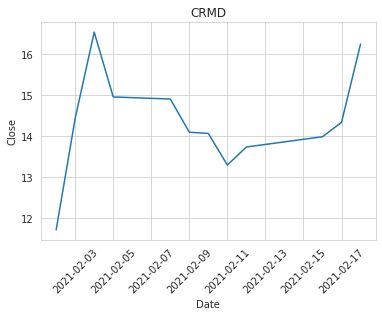

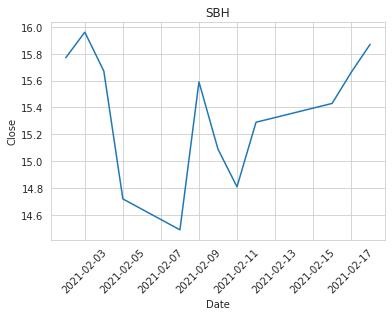

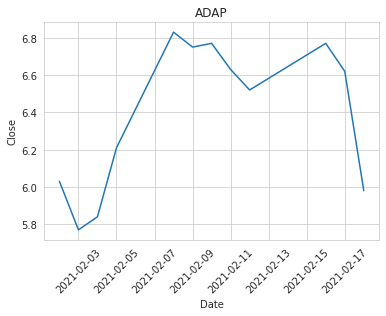

In [ ]:
for ticker in tickers_to_watch:
    data = pdr.get_data_yahoo(ticker, start=datetime.strptime(date_before_before, '%Y%m%d').date()-timedelta(days=14), end=datetime.strptime(date_start, '%Y%m%d').date())
    plt.figure()
    sns.lineplot(data=data, x="Date", y="Close").set_title(ticker)
    plt.xticks(rotation=45)

Checking prices of the previously acuired tickers to see how the price changed the following day and setting an optimal take profit if we decided to open a trade.

In [ ]:
results = pd.DataFrame(columns=['PriceYesterday','PriceToday','DifOpenAndTodayHigh'])

tickers_to_watch = ['CRMD', 'SBH', 'ADAP']

for ticker in tickers_to_watch:
    data = pdr.get_data_yahoo(ticker, start='2021-02-18', end='2021-02-19')
    temp = pd.DataFrame(
          {
            'PriceYesterday': data.Close.iloc[0],                     
            'PriceToday': data.Close.iloc[1],
            'DifOpenAndTodayHigh': data.High.iloc[1] - data.Open.iloc[1]
          }, index=[ticker]
    )
    results = pd.concat([results, temp])
    
results['DifPercent'] = results.DifOpenAndTodayHigh/results.PriceToday
results  

,PriceYesterday,PriceToday,DifOpenAndTodayHigh,DifPercent
CRMD,16.25,17.58,2.099998,0.119454
SBH,15.87,15.70,0.190001,0.012102
ADAP,5.98,6.29,0.270000,0.042925


In [ ]:
print('Place Take Profit at ' + str(round(results.DifPercent.mean()*100, 2)) + '%')

Place Take Profit at 5.82%


#2 out of 3 stocks closed higher than they did yesterday and all of them had positive highs, so if we to implement that strategy we need to place a take profit on the opening of the market at 5%.